In [1]:
import tensorflow as tf

### Import necessary libraries

In [2]:
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt
import json
import seaborn as sns

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Activation, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from PIL import Image, ImageChops, ImageEnhance
from tqdm.notebook import tqdm

### Error Level Analysis

In [3]:
#converts input image to ela applied image
def convert_to_ela_image(path,quality):

    original_image = Image.open(path).convert('RGB')

    #resaving input image at the desired quality
    resaved_file_name = 'resaved_image.jpg'     #predefined filename for resaved image
    original_image.save(resaved_file_name,'JPEG',quality=quality)
    resaved_image = Image.open(resaved_file_name)

    #pixel difference between original and resaved image
    ela_image = ImageChops.difference(original_image,resaved_image)
    
    #scaling factors are calculated from pixel extremas
    extrema = ela_image.getextrema()
    max_difference = max([pix[1] for pix in extrema])
    if max_difference ==0:
        max_difference = 1
    scale = 350.0 / max_difference
    
    #enhancing elaimage to brighten the pixels
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    ela_image.save("ela_image.png")
    return ela_image

### Dataset Preparation

In [4]:
def prepare_image(image_path):
    image_size = (128, 128)
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0         #normalizing the array values obtained from input image

In [5]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

In [6]:
#adding authentic images

path = r'C:\Users\Jashanpreet Singh\Desktop\STGI\dataset\CASIA2\Au'    #folder path of the authentic images in the dataset
for filename in tqdm(os.listdir(path),desc="Processing Images : "):
    if filename.endswith('jpg') or filename.endswith('png'):
        full_path = os.path.join(path, filename)
        X.append(prepare_image(full_path))        
        Y.append(1)     # label for authentic images 
        
print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')

Processing Images :   0%|          | 0/7492 [00:00<?, ?it/s]

Total images: 7354
Total labels: 7354


In [7]:
#adding forged images

path = r'C:\Users\Jashanpreet Singh\Desktop\STGI\dataset\CASIA2\Tp'       #folder path of the forged images in the dataset
for filename in tqdm(os.listdir(path),desc="Processing Images : "):
    if filename.endswith('jpg') or filename.endswith('png'):
        full_path = os.path.join(path, filename)
        X.append(prepare_image(full_path))        
        Y.append(0)     # label for forged images 
        
print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')

Processing Images :   0%|          | 0/5124 [00:00<?, ?it/s]

Total images: 9418
Total labels: 9418


In [8]:
X = np.array(X)
Y = np.array(Y)
X = X.reshape(-1, 128, 128, 3) 

### Partitioning dataset for training, validation and testing

In [9]:
X_next, X_unseen, Y_next, Y_unseen = train_test_split(X, Y, test_size = 0.1, random_state=5)

print(f'Training images: {len(X_next)} , Training labels: {len(Y_next)}')
print(f'Unseen images: {len(X_unseen)} , Test labels: {len(Y_unseen)}')

Training images: 8476 , Training labels: 8476
Unseen images: 942 , Test labels: 942


### CNN Model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

def build_model():
    model = Sequential()  # Sequential Model
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    return model


In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [15]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

accuracies = []

# Iterate through the K-Folds
for train_index, test_index in skf.split(X_next, Y_next):
    X_train, X_test = X_next[train_index], X_next[test_index]
    y_train, y_test = Y_next[train_index], Y_next[test_index]
    
    # Build a new model for each fold
    model = build_model()
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
    
    # Evaluate the model on the test fold
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Fold accuracy: {accuracy}")

# Calculate and print the average accuracy across all folds
print(f"Average accuracy: {np.mean(accuracies)}")

C:\Users\Jashanpreet Singh\Desktop\STGI\tenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 192s 889ms/step - accuracy: 0.8595 - loss: 0.3014 - val_accuracy: 0.7789 - val_loss: 1.4221
Epoch 2/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 188s 885ms/step - accuracy: 0.9149 - loss: 0.1940 - val_accuracy: 0.7789 - val_loss: 0.6866
Epoch 3/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 187s 884ms/step - accuracy: 0.9248 - loss: 0.1790 - val_accuracy: 0.8750 - val_loss: 0.2914
Epoch 4/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 189s 889ms/step - accuracy: 0.9380 - loss: 0.1409 - val_accuracy: 0.9458 - val_loss: 0.1447
Epoch 5/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 186s 879ms/step - accuracy: 0.9452 - loss: 0.1283 - val_accuracy: 0.9534 - val_loss: 0.1104
Epoch 6/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 187s 880ms/step - accuracy: 0.9531 - loss: 0.1117 - val_accuracy: 0.9558 - val_loss: 0.1215
Epoch 7/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 188s 885ms/step - accuracy: 0.9542 - loss: 0.1131 - val_accuracy: 0.5478 - val_loss: 1.4122
Epoch 8/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 191s 901ms/step - accuracy: 0.9537 -

C:\Users\Jashanpreet Singh\Desktop\STGI\tenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 197s 909ms/step - accuracy: 0.8351 - loss: 0.3672 - val_accuracy: 0.7794 - val_loss: 1.6735
Epoch 2/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 191s 901ms/step - accuracy: 0.9069 - loss: 0.2225 - val_accuracy: 0.7794 - val_loss: 1.2224
Epoch 3/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 191s 900ms/step - accuracy: 0.9290 - loss: 0.1672 - val_accuracy: 0.7735 - val_loss: 0.4289
Epoch 4/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 187s 882ms/step - accuracy: 0.9331 - loss: 0.1579 - val_accuracy: 0.9404 - val_loss: 0.1722
Epoch 5/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 191s 902ms/step - accuracy: 0.9417 - loss: 0.1348 - val_accuracy: 0.7091 - val_loss: 0.5229
Epoch 6/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 191s 902ms/step - accuracy: 0.9437 - loss: 0.1336 - val_accuracy: 0.9062 - val_loss: 0.2589
Epoch 7/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 191s 902ms/step - accuracy: 0.9458 - loss: 0.1276 - val_accuracy: 0.9410 - val_loss: 0.2091
Epoch 8/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 191s 900ms/step - accuracy: 0.9469 -

C:\Users\Jashanpreet Singh\Desktop\STGI\tenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 198s 914ms/step - accuracy: 0.8597 - loss: 0.2997 - val_accuracy: 0.7788 - val_loss: 0.7840
Epoch 2/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 195s 918ms/step - accuracy: 0.9152 - loss: 0.1936 - val_accuracy: 0.7788 - val_loss: 0.5783
Epoch 3/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 192s 906ms/step - accuracy: 0.9329 - loss: 0.1505 - val_accuracy: 0.7735 - val_loss: 0.3864
Epoch 4/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 192s 905ms/step - accuracy: 0.9443 - loss: 0.1376 - val_accuracy: 0.9251 - val_loss: 0.2130
Epoch 5/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 192s 908ms/step - accuracy: 0.9502 - loss: 0.1283 - val_accuracy: 0.5233 - val_loss: 1.0286
Epoch 6/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 1992s 9s/step - accuracy: 0.9491 - loss: 0.1157 - val_accuracy: 0.6867 - val_loss: 0.4728
Epoch 7/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 1558s 7s/step - accuracy: 0.9537 - loss: 0.1062 - val_accuracy: 0.9440 - val_loss: 0.1300
Epoch 8/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 191s 902ms/step - accuracy: 0.9505 - los

C:\Users\Jashanpreet Singh\Desktop\STGI\tenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 205s 937ms/step - accuracy: 0.8381 - loss: 0.3363 - val_accuracy: 0.7788 - val_loss: 0.5634
Epoch 2/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 194s 916ms/step - accuracy: 0.9120 - loss: 0.2062 - val_accuracy: 0.7788 - val_loss: 0.7811
Epoch 3/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 193s 912ms/step - accuracy: 0.9302 - loss: 0.1651 - val_accuracy: 0.7351 - val_loss: 0.5079
Epoch 4/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 194s 917ms/step - accuracy: 0.9366 - loss: 0.1595 - val_accuracy: 0.7493 - val_loss: 0.4596
Epoch 5/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 194s 915ms/step - accuracy: 0.9479 - loss: 0.1324 - val_accuracy: 0.9504 - val_loss: 0.1364
Epoch 6/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 193s 912ms/step - accuracy: 0.9516 - loss: 0.1274 - val_accuracy: 0.9463 - val_loss: 0.1385
Epoch 7/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 194s 913ms/step - accuracy: 0.9545 - loss: 0.1161 - val_accuracy: 0.9139 - val_loss: 0.2251
Epoch 8/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 826s 4s/step - accuracy: 0.9525 - lo

C:\Users\Jashanpreet Singh\Desktop\STGI\tenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 199s 919ms/step - accuracy: 0.8409 - loss: 0.3330 - val_accuracy: 0.7788 - val_loss: 0.9715
Epoch 2/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 308s 1s/step - accuracy: 0.9120 - loss: 0.2051 - val_accuracy: 0.7788 - val_loss: 0.9961
Epoch 3/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 192s 905ms/step - accuracy: 0.9308 - loss: 0.1665 - val_accuracy: 0.8354 - val_loss: 0.3388
Epoch 4/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 192s 906ms/step - accuracy: 0.9349 - loss: 0.1566 - val_accuracy: 0.8342 - val_loss: 0.4337
Epoch 5/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 520s 2s/step - accuracy: 0.9422 - loss: 0.1372 - val_accuracy: 0.7794 - val_loss: 0.4855
Epoch 6/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 192s 906ms/step - accuracy: 0.9487 - loss: 0.1186 - val_accuracy: 0.8985 - val_loss: 0.2399
Epoch 7/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 192s 905ms/step - accuracy: 0.9462 - loss: 0.1229 - val_accuracy: 0.9280 - val_loss: 0.1884
Epoch 8/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 193s 908ms/step - accuracy: 0.9553 - loss:

### Confusion Matrix

In [17]:
def plot_confusion_matrix(cf_matrix):
  
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()] #number of images in each classification block
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)] #percentage value of images in each block w.r.t total images

    axes_labels=['Forged', 'Authentic']
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='',cmap="flare" , xticklabels=axes_labels, yticklabels=axes_labels)

    plot_xlabel = plt.xlabel('Predicted labels', fontsize = 13)
    plot_ylabel = plt.ylabel('True labels', fontsize = 13)
    plot_title = plt.title('Confusion Matrix', fontsize= 10,fontweight='bold')

30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step


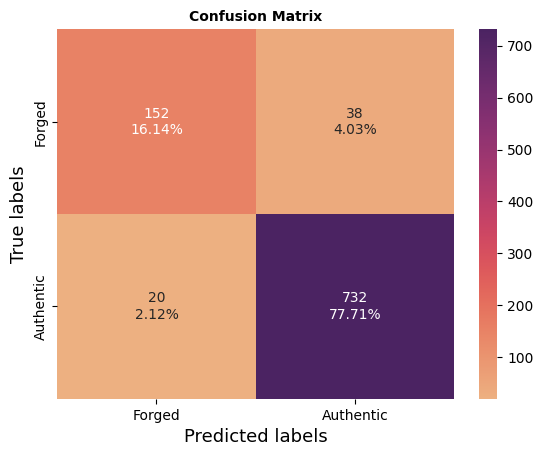

In [19]:
Y_pred = model.predict(X_unseen)               # Predict the values from the validation dataset 
Y_pred_classes = np.round(Y_pred)           # roundoff the sigmoid value
Y_true = Y_unseen                             

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)     # compute the confusion matrix
plot_confusion_matrix(confusion_mtx)                         # plot the confusion matrix


### Classification Report

In [20]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84       190
           1       0.95      0.97      0.96       752

    accuracy                           0.94       942
   macro avg       0.92      0.89      0.90       942
weighted avg       0.94      0.94      0.94       942



### Testing Accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Prediction: Forged
Confidence:  100.00%
--------------------------------------------------------------------------------------------------------------


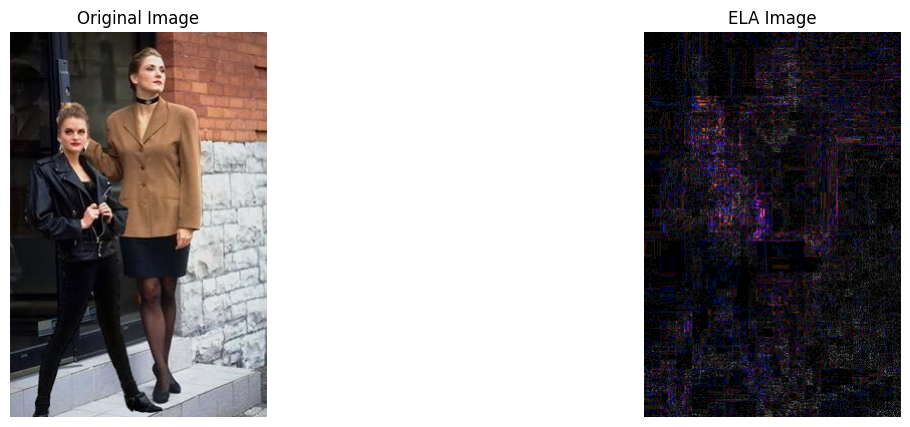

In [40]:
test_image_path = r'/Users/vishwaskisaniya/Downloads/CASIA2/Tp/Tp_D_CNN_M_N_cha00026_cha00028_11784.jpg'   # test image path
test_image = prepare_image(test_image_path)
test_image = test_image.reshape(-1, 128, 128, 3)

y_pred = model.predict(test_image)
y_pred_class = round(y_pred[0][0])

fig, ax = plt.subplots(1,2,figsize=(15,5)) 

#display original image
original_image = plt.imread(test_image_path) 
ax[0].axis('off')
ax[0].imshow(original_image)
ax[0].set_title('Original Image')

#display ELA applied image
ax[1].axis('off')
ax[1].imshow(convert_to_ela_image(test_image_path,90)) 
ax[1].set_title('ELA Image')

print(f'Prediction: {class_names[y_pred_class]}')
if y_pred<=0.5:
    print(f'Confidence:  {(1-(y_pred[0][0])) * 100:0.2f}%')
else:
    print(f'Confidence: {(y_pred[0][0]) * 100:0.2f}%')
print('--------------------------------------------------------------------------------------------------------------')